In [16]:
! pip install opencv-python
! pip install ftfy regex tqdm
! pip install streamlit
! pip install torchray

In [15]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
sys.path.append("/scratch/students/2021-fall-sp-mamooler/sem_project_IVRL/code/")

import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import numpy as np
import cv2
import json
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from model import build_model
from clip_ import load, tokenize, similarity_score
from vit_cam import interpret_vit, interpret_vit_overlapped, vit_relevance
from rn_cam import interpret_rn, interpret_rn_overlapped, rn_relevance
sys.path.append("/scratch/students/2021-fall-sp-mamooler/sem_project_IVRL/code/pytorch-grad-cam")
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
model_rn, preprocess = load("RN50", device=device, jit=False)
model_vit, preprocess = load("ViT-B/32", device=device, jit=False)

In [18]:
model_types = ["ViT", "RN50"]

font = {
    'size': 15,
}

ori_preprocess = Compose([
        Resize((224), interpolation=Image.BICUBIC),
        CenterCrop(size=(224, 224)),
        ToTensor()])

res_dir = "../../results/affectnet/"
if not os.path.exists(res_dir):
    os.mkdir(res_dir)

# Attention Bias

In [19]:
image_ids = []
root = "../../Images/affectnet_samples/"
texts  = ["this person is sad", "this person is happy"]
for directory in os.listdir(root):
    for file in os.listdir(root+directory):
        if file.endswith(".jpg"):
            image_ids.append(f"{directory}/{file}")

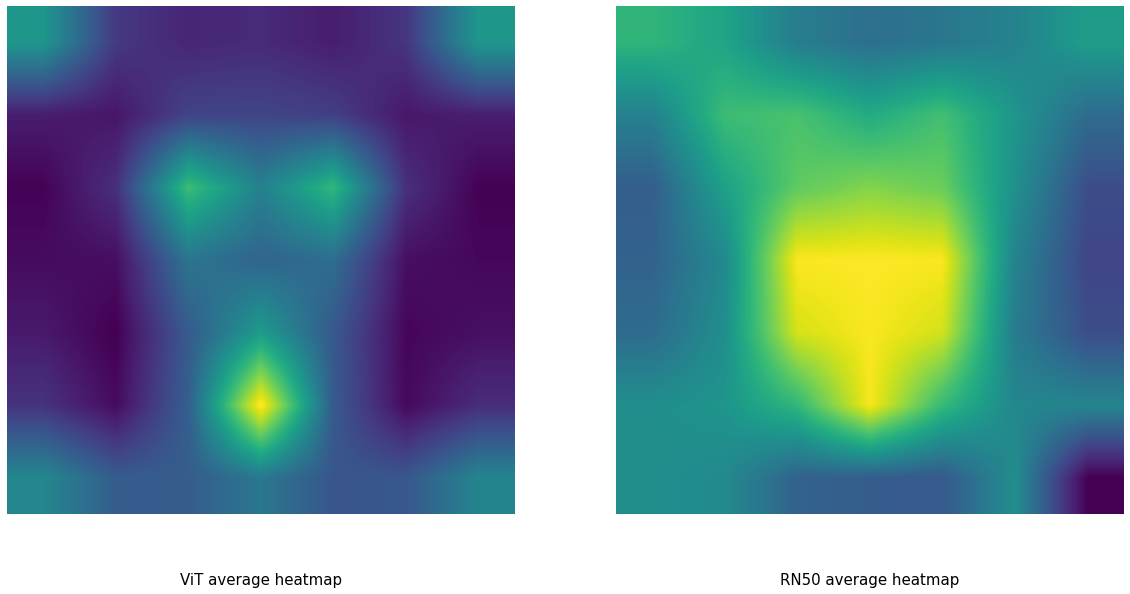

In [21]:
plt.figure(figsize=(20, 20))

for model_id, model_type in enumerate(model_types):  
    
    for id_, img_id in enumerate(image_ids):

        img_path =  os.path.join(root, img_id)
        image = ori_preprocess(Image.open(img_path))
        p_image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

        for i,text in enumerate(texts):
            t_text = tokenize(text).to(device)
            
            if model_type=="ViT":
                text_features = model_vit.encode_text(t_text)
                relevance, _ = vit_relevance(p_image.type(model_vit.dtype), text_features, model_vit.visual, device, use_last_grad=False)
                
            else:
                text_features = model_rn.encode_text(t_text)
                relevance, _ = rn_relevance(p_image.type(model_rn.dtype), text_features, model_rn.visual, GradCAM, device)
                
            relevance = np.expand_dims(relevance, axis=0)
            if id_ == 0:
                attentions = relevance
            else:
                attentions = np.concatenate((attentions, relevance), axis=0)
            
                
    mean = np.mean(attentions, axis=0)
    mean = np.float32(mean/np.max(mean))
    
    plt.subplot(1,2,1+model_id)
    plt.imshow(mean)
    plt.axis('off')
    plt.title(f"{model_type} average heatmap", **font, y=-0.15)
    
plt.savefig(res_dir + 'attention_bias.png', bbox_inches='tight')

In [262]:
import math

In [265]:
def margin_of_error(p, n):
    return 2*math.sqrt((p*(1-p))/n)

for p in [0.952, 0.788, 0.01, 0.044, 0.162, 0.058]:
    print(margin_of_error(p, 500))

0.01911983263525077
0.036557461618662745
0.008899438184514795
0.018344263408488222
0.032955242375075924
0.020906649659857026


In [13]:
print(attentions.shape)

(447776, 224)
